<a href="https://colab.research.google.com/github/BiakkoNoMiko/homework_projects/blob/main/Convolutional%20NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Домашнее задание по Python #39 «Свёрточные сети» Лузановой Е.В.
Курс: dsn-cp-2

Здесь вам предстоит построить и обучить свою первую свёрточную сеть для классификации изображений на данных CIFAR10.



In [ ]:
import tensorflow as tf

from tqdm.notebook import tqdm #декоратор прогрессбара
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

## Данные

CIFAR10
* 60000 RGB изображений размером 32x32x3
* 10 классов: самолёты, собаки, рыбы и т.п.

<img src="https://www.samyzaf.com/ML/cifar10/cifar1.jpg" style="width:60%">

Загрузите данные, разделите их на обучающую и тестовую выборки. Размер тестовой выборки должен быть $10^4$.

In [ ]:
import numpy as np
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=10**4, random_state=42)

class_names = np.array(['airplane','automobile ','bird ','cat ','deer ','dog ','frog ','horse ','ship ','truck'])

print (X_train.shape,y_train.shape)

(40000, 32, 32, 3) (40000, 1)


In [ ]:
unique, counts = np.unique(y_train, return_counts=True)
print(np.asarray((unique, counts/len(y_train)*100)).T)

[[ 0.     10.0675]
 [ 1.     10.0525]
 [ 2.      9.925 ]
 [ 3.      9.9425]
 [ 4.     10.1675]
 [ 5.      9.9625]
 [ 6.     10.01  ]
 [ 7.     10.015 ]
 [ 8.      9.9575]
 [ 9.      9.9   ]]


:# в тест идет 40 000 картинок, 32х32, rgb. Данные идеально сбалансированы по классам.

Прежде чем приступать к основной работе, стоит убедиться что загруженно именно то, что требовалось:

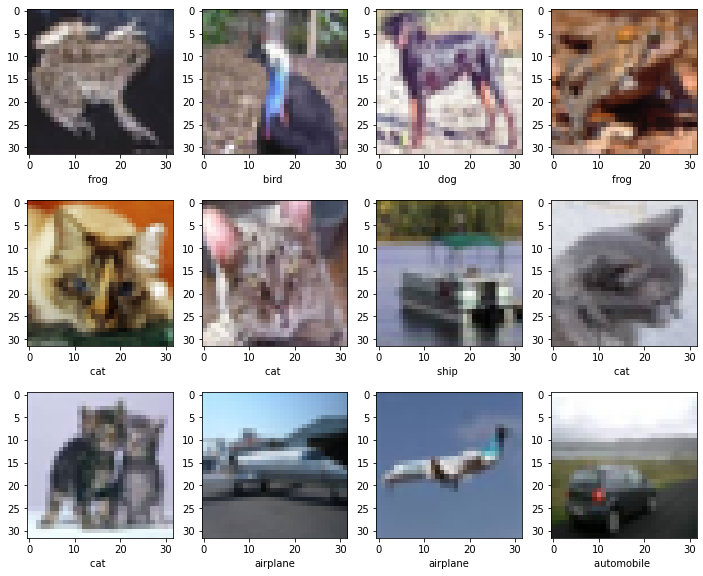

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.xlabel(class_names[y_train[i, 0]])
    plt.imshow(X_train[i])

## Подготовка данных

Сейчас каждый пиксель изображения закодирован тройкой чисел (RGB) __от 0 до 255__. Однако лучше себя показывает подход, где значения входов нейросети распределены недалеко от 0.

Давайте приведём все данные в диапазон __`[0, 1]`__ — просто разделим на соответствующий коэффициент:

+ переведем во флоат

In [ ]:
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

Исполните код ниже для проверки, что все выполнено корректно.

Assertions (утверждения) — это инструкции, которые «утверждают» определенный кейс в программе. В Python они выступают булевыми выражениями, которые проверяют, является ли условие истинным или ложным. Если оно истинно, то программа ничего не делает и переходит к выполнению следующей строчки кода.

In [ ]:
assert np.shape(X_train) == (40000, 32, 32, 3), "data shape should not change"
assert 0.9 <= max(map(np.max, (X_train, X_val, X_test))) <= 1.05
assert 0.0 <= min(map(np.min, (X_train, X_val, X_test))) <= 0.1
assert len(np.unique(X_test / 255.)) > 10, "make sure you casted data to float type"

## Архитектура сети

Для начала реализуйте простую нейросеть:
1. принимает на вход картинки размера 32 x 32 x 3;
2. вытягивает их в вектор (`keras.layers.Flatten`);
3. пропускает через 1 или 2 полносвязных слоя;
4. выходной слой отдает вероятности принадлежности к каждому из 10 классов.

Создайте полносвязную сеть:

In [ ]:
import keras
from keras import layers


In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = X_train.shape[1:]),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(10, activation='softmax')])

model.summary()


Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_39 (Flatten)        (None, 3072)              0         
                                                                 
 dense_121 (Dense)           (None, 128)               393344    
                                                                 
 dropout_82 (Dropout)        (None, 128)               0         
                                                                 
 dense_122 (Dense)           (None, 64)                8256      
                                                                 
 dropout_83 (Dropout)        (None, 64)                0         
                                                                 
 dense_123 (Dense)           (None, 10)                650       
                                                                 
Total params: 402,250
Trainable params: 402,250
Non-t

In [ ]:
3073*128-393344

0

In [ ]:
dummy_pred = model.predict(X_train[:20])
assert dummy_pred.shape == (20, 10)
assert np.allclose(dummy_pred.sum(-1), 1)
print("Успех!")

1/1 [==============================] - 4s 4s/step
Успех!


## Обучение сети

**Задание 1.1 (обязательно)** Будем минимизировать многоклассовую кроссэкнропию с помощью __sgd__. Вам нужно получить сеть, которая достигнет __не менее 45%__ __accuracy__ на тестовых данных.

__Важно:__ поскольку в y_train лежат номера классов, Керасу нужно либо указать sparse функции потерь и метрики оценки качества классификации (`sparse_categorical_crossentropy` и `sparse_categorical_accuracy`), либо конвертировать метки в one-hot формат.

### Полезные советы
* `model.compile` позволяет указать, какие метрики вы хотите вычислять.
* В `model.fit` можно передать валидационную выборку (`validation_data=[X_val, y_val]`), для отслеживания прогресса на ней. Также рекомендуем сохранять результаты в [tensorboard](https://keras.io/callbacks/#tensorboard) или [wandb](https://docs.wandb.ai/integrations/jupyter). **Важно: логи tensorboard не получится без боли посмотреть через colab.** Workaround: скачать логи и запустить tensorboard локально или помучаться [с этим](https://stackoverflow.com/questions/47818822/can-i-use-tensorboard-with-google-colab).
* По умолчанию сеть учится 1 эпоху. Совсем не факт, что вам этого хватит. Число эпох можно настроить в методе `fit` (`epochs`).
* Ещё у Кераса есть много [полезных callback-ов](https://keras.io/callbacks/), которые можно попробовать. Например, автоматическая остановка или подбор скорости обучения.

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd',
                  metrics=['sparse_categorical_accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint
import time
# train our model and save the best results in the file: MLP.best_weights
# additionally count the time how long it took

mlp_start = time.time() # for stopwatch

checkpointer = ModelCheckpoint(filepath='MLP.best_weights.hdf5', verbose=1,
                               save_best_only=True)
hist = model.fit(X_train, y_train, batch_size=512, epochs=15,
          validation_data=(X_val, y_val), callbacks=[checkpointer],
          verbose=2, shuffle=True)

mlp_end = time.time()
mlp_took = mlp_end -mlp_start
print("took %s seconds"%(mlp_took))

Epoch 1/15

Epoch 1: val_loss improved from inf to 2.17701, saving model to MLP.best_weights.hdf5
79/79 - 259s - loss: 2.2747 - sparse_categorical_accuracy: 0.1424 - val_loss: 2.1770 - val_sparse_categorical_accuracy: 0.2147 - 259s/epoch - 3s/step
Epoch 2/15

Epoch 2: val_loss improved from 2.17701 to 2.10455, saving model to MLP.best_weights.hdf5
79/79 - 6s - loss: 2.1830 - sparse_categorical_accuracy: 0.1854 - val_loss: 2.1045 - val_sparse_categorical_accuracy: 0.2426 - 6s/epoch - 79ms/step
Epoch 3/15

Epoch 3: val_loss improved from 2.10455 to 2.05549, saving model to MLP.best_weights.hdf5
79/79 - 5s - loss: 2.1311 - sparse_categorical_accuracy: 0.2095 - val_loss: 2.0555 - val_sparse_categorical_accuracy: 0.2871 - 5s/epoch - 58ms/step
Epoch 4/15

Epoch 4: val_loss improved from 2.05549 to 2.02365, saving model to MLP.best_weights.hdf5
79/79 - 5s - loss: 2.0938 - sparse_categorical_accuracy: 0.2269 - val_loss: 2.0237 - val_sparse_categorical_accuracy: 0.2985 - 5s/epoch - 59ms/step
Ep

А теперь можно проверить качество вашей сети, выполнив код ниже:

In [ ]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

313/313 [==============================] - 5s 6ms/step


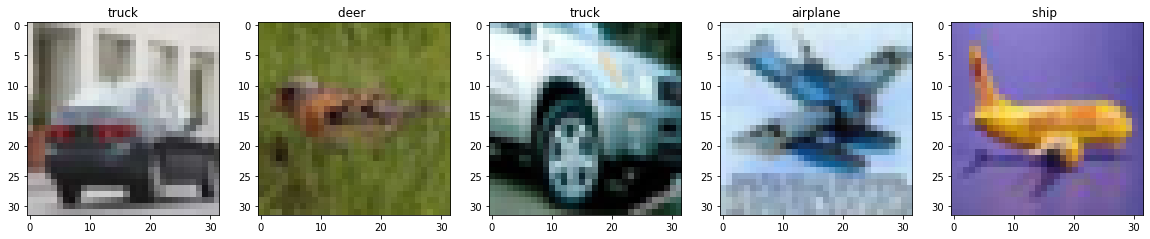

In [ ]:
fig = plt.figure(figsize=(20, 10))
indices = np.random.choice(range(len(X_test)), 5)
img_prediction = zip(X_test[indices], y_pred_labels[indices])
for i, (img, pred) in enumerate(img_prediction, 1):
    subplot = fig.add_subplot(1, 5, i)
    plt.imshow(img);
    subplot.set_title(class_names[pred]);

In [ ]:
model.load_weights('MLP.best_weights.hdf5')
mlp_score = model.evaluate(X_test, y_test, verbose=0)
print('\n', 'Test accuracy:', mlp_score[1])


 Test accuracy: 0.3594000041484833


## Карманная сверточная сеть

**Задание 1.2 (обязательно)** Реализуйте небольшую свёрточную сеть. Совсем небольшую:
1. Входной слой
2. Свёртка 3x3 с 10 фильтрами
3. Нелинейность на ваш вкус
4. Max-pooling 2x2
5. Вытягиваем оставшееся в вектор (Flatten)
6. Полносвязный слой на 100 нейронов
7. Нелинейность на ваш вкус
8. Выходной полносвязный слой с softmax

Обучите её так же, как и предыдущую сеть. Если всё хорошо, у вас получится accuracy не меньше __50%__.

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=10,
                        kernel_size=(3, 3),
                        padding='same',
                        activation='relu',
                        input_shape=X_train.shape[1:]),
    keras.layers.AveragePooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(input_shape = X_train.shape[1:]),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(10, activation='softmax')])

model.summary()


Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 32, 32, 10)        280       
                                                                 
 average_pooling2d_40 (Avera  (None, 16, 16, 10)       0         
 gePooling2D)                                                    
                                                                 
 flatten_40 (Flatten)        (None, 2560)              0         
                                                                 
 dense_124 (Dense)           (None, 128)               327808    
                                                                 
 batch_normalization_117 (Ba  (None, 128)              512       
 tchNormalization)                                               
                                                                 
 dropout_84 (Dropout)        (None, 128)             

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd',
                  metrics=['sparse_categorical_accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint
import time
# train our model and save the best results in the file: MLP.best_weights
# additionally count the time how long it took

mlp_start = time.time() # for stopwatch

checkpointer = ModelCheckpoint(filepath='MLP.best_weights.hdf5', verbose=1,
                               save_best_only=True)
hist = model.fit(X_train, y_train, batch_size=32, epochs=15,
          validation_data=(X_val, y_val), callbacks=[checkpointer],
          verbose=2, shuffle=True)

mlp_end = time.time()
mlp_took = mlp_end -mlp_start
print("took %s seconds"%(mlp_took))

Epoch 1/15

Epoch 1: val_loss improved from inf to 1.62977, saving model to MLP.best_weights.hdf5
1250/1250 - 38s - loss: 2.0136 - sparse_categorical_accuracy: 0.2982 - val_loss: 1.6298 - val_sparse_categorical_accuracy: 0.4112 - 38s/epoch - 30ms/step
Epoch 2/15

Epoch 2: val_loss improved from 1.62977 to 1.55585, saving model to MLP.best_weights.hdf5
1250/1250 - 29s - loss: 1.6823 - sparse_categorical_accuracy: 0.3922 - val_loss: 1.5559 - val_sparse_categorical_accuracy: 0.4386 - 29s/epoch - 23ms/step
Epoch 3/15

Epoch 3: val_loss improved from 1.55585 to 1.54873, saving model to MLP.best_weights.hdf5
1250/1250 - 28s - loss: 1.6019 - sparse_categorical_accuracy: 0.4188 - val_loss: 1.5487 - val_sparse_categorical_accuracy: 0.4458 - 28s/epoch - 22ms/step
Epoch 4/15

Epoch 4: val_loss improved from 1.54873 to 1.46333, saving model to MLP.best_weights.hdf5
1250/1250 - 28s - loss: 1.5620 - sparse_categorical_accuracy: 0.4378 - val_loss: 1.4633 - val_sparse_categorical_accuracy: 0.4688 - 28

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_labels))

              precision    recall  f1-score   support

           0       0.35      0.55      0.43      1000
           1       0.37      0.48      0.42      1000
           2       0.30      0.07      0.11      1000
           3       0.32      0.14      0.20      1000
           4       0.31      0.41      0.35      1000
           5       0.32      0.36      0.34      1000
           6       0.37      0.40      0.38      1000
           7       0.51      0.22      0.31      1000
           8       0.40      0.50      0.45      1000
           9       0.38      0.46      0.42      1000

    accuracy                           0.36     10000
   macro avg       0.36      0.36      0.34     10000
weighted avg       0.36      0.36      0.34     10000



Давайте посмотрим, смогла ли карманная сверточная сеть побить заданный порог по качеству:

In [ ]:
from sklearn.metrics import accuracy_score
test_acc = mlp_score = model.evaluate(X_test, y_test, verbose=0)
print("\n Test_acc =", test_acc[1])
assert test_acc[1] > 0.50, "Not good enough. Back to the drawing board :)"
print(" Not bad!")


 Test_acc = 0.5425999760627747
 Not bad!


## Учимся учить

А теперь научимся сравнивать кривые обучения моделей — зависимости значения accuracy от количества итераций.

Вам потребуется реализовать _экспериментальный стенд_ — вспомогательный код, в который вы сможете подать несколько архитектур и методов обучения, чтобы он их обучил и вывел графики кривых обучения. Это можно сделать с помощью `keras.callbacks` — `TensorBoard` или `History`.

Будьте морально готовы, что на обучение уйдёт _много времени_. Даже если вы ограничитесь 10 эпохами. Пока идёт обучение, вы можете переключиться на другие задания или заняться чем-нибудь приятным: поспать, например.

**Задание 1.3 (опционально)** Попробуйте использовать различные методы оптимизации (sgd, momentum, adam) с параметрами по умолчанию. Какой из методов работает лучше?

Для удобства напишем класс Evaluator, который принимает в себя дикты виды {имя_оптимайзера: инстанс}, {имя модели: инстанс} и обучает всевозможные комбинации моделей с оптимайзерами при помощи метода fit (попутно записывая логи отдельно для каждой модели). Также пригодится метод evaluate для отображения итоговых скоров.

Пользоваться классом не обязательно. По умолчанию класс использует tensorboard. Если вы выше использовали wandb -- советуем дописать callback.

In [ ]:
class Evaluator(list):
    def __init__(self, models, optimizers='adam'
                 ):
        '''
            models: dict {name: model}
            optimizers: list of optimizers or just one optimizer
        '''
        if not isinstance(models, dict):
            models = {'single_model': models}
        if not isinstance(optimizers, dict):
            optimizers = {str(optimizers.__class__): optimizers}
        super().__init__([(model_name, keras.models.clone_model(model), optimizer_name, optimizer)
                          for model_name, model in models.items()
                          for optimizer_name, optimizer in optimizers.items()])
        for _, model, _, optimizer in self:
            model.compile(optimizer=optimizer, loss=['sparse_categorical_crossentropy'], metrics=['sparse_categorical_accuracy'])

    def fit(self, X, y, validation_data=(), max_epochs=20, verbose=0, callbacks=[], batch_size=1024):
        if not isinstance(callbacks, list):
            callbacks = [callbacks]
        for model_name, model, optimizer_name, optimizer in tqdm(self):
            model.fit(X, y, validation_data=validation_data or None, epochs=max_epochs, verbose=verbose,
                      batch_size=batch_size, callbacks=callbacks + [keras.callbacks.TensorBoard(
                          log_dir='./logs/{}_{}'.format(model_name, optimizer_name))])

    def fit_generator(self, X, y, validation_data=(), max_epochs=100, verbose=1, callbacks=[], batch_size=32):
        datagen = keras.preprocessing.image.ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True
        )
        if not isinstance(callbacks, list):
            callbacks = [callbacks]
        for model_name, model, optimizer_name, optimizer in tqdm(self):
            model.fit_generator(datagen.flow(X, y, batch_size=batch_size), epochs=max_epochs,
                validation_data=validation_data or None, verbose=verbose,
                callbacks=callbacks + [keras.callbacks.TensorBoard(
                    log_dir='./logs/{}_{}'.format(model_name, optimizer_name))])

    def evaluate(self, X, y, metric):
        for model_name, model, optimizer_name, _ in self:
            print('Final score of {}_{} is {}'.format(model_name, optimizer_name,
                  metric(y_test, np.argmax(model.predict(X_test), axis=1))))

In [ ]:
optimizers = {
    'SGD': 'SGD',
    'RMSprop': 'RMSprop',
    'Adam': 'Adam'
    }

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3) #patience - Number of epochs with no improvement after which training will be stopped

evaluator = Evaluator(model, optimizers=optimizers)
evaluator.fit(X_train, y_train, validation_data=(X_val, y_val))
evaluator.evaluate(X_test, y_test, accuracy_score)

  0%|          | 0/3 [00:00<?, ?it/s]

313/313 [==============================] - 3s 8ms/step
Final score of single_model_SGD is 0.4292
313/313 [==============================] - 3s 8ms/step
Final score of single_model_RMSprop is 0.5181
313/313 [==============================] - 3s 9ms/step
Final score of single_model_Adam is 0.5891


Adam ожидаемо выдал наилучший результат среди трех оптимизаторов (больше проверять не буду, т.к. ресурсов не хватает у машинки.

**Задание 1.4 (опционально)** Добавьте нормализацию по батчу (`BatchNormalization`) между свёрткой и активацией. Попробуйте использовать несколько нормализаций — в свёрточных и полносвязных слоях.

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=10,
                        kernel_size=(3, 3),
                        padding='same',
                        activation='relu',
                        input_shape=X_train.shape[1:]),
    keras.layers.AveragePooling2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(),
    keras.layers.Flatten(input_shape = X_train.shape[1:]),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(10, activation='softmax')])

model.summary()

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_41 (Conv2D)          (None, 32, 32, 10)        280       
                                                                 
 average_pooling2d_41 (Avera  (None, 16, 16, 10)       0         
 gePooling2D)                                                    
                                                                 
 batch_normalization_119 (Ba  (None, 16, 16, 10)       40        
 tchNormalization)                                               
                                                                 
 flatten_41 (Flatten)        (None, 2560)              0         
                                                                 
 dense_127 (Dense)           (None, 128)               327808    
                                                                 
 batch_normalization_120 (Ba  (None, 128)            

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',
                  metrics=['sparse_categorical_accuracy'])

In [ ]:
mlp_start = time.time() # for stopwatch

checkpointer = ModelCheckpoint(filepath='MLP.best_weights.hdf5', verbose=1,
                               save_best_only=True)
hist = model.fit(X_train, y_train, batch_size=512, epochs=15,
          validation_data=(X_val, y_val), callbacks=[checkpointer],
          verbose=2, shuffle=True)

mlp_end = time.time()
mlp_took = mlp_end -mlp_start
print("took %s seconds"%(mlp_took))

Epoch 1/15

Epoch 1: val_loss improved from inf to 2.08263, saving model to MLP.best_weights.hdf5
79/79 - 225s - loss: 2.0153 - sparse_categorical_accuracy: 0.3243 - val_loss: 2.0826 - val_sparse_categorical_accuracy: 0.2678 - 225s/epoch - 3s/step
Epoch 2/15

Epoch 2: val_loss improved from 2.08263 to 2.00071, saving model to MLP.best_weights.hdf5
79/79 - 53s - loss: 1.5928 - sparse_categorical_accuracy: 0.4356 - val_loss: 2.0007 - val_sparse_categorical_accuracy: 0.3011 - 53s/epoch - 676ms/step
Epoch 3/15

Epoch 3: val_loss improved from 2.00071 to 1.95041, saving model to MLP.best_weights.hdf5
79/79 - 29s - loss: 1.3964 - sparse_categorical_accuracy: 0.5015 - val_loss: 1.9504 - val_sparse_categorical_accuracy: 0.3138 - 29s/epoch - 371ms/step
Epoch 4/15

Epoch 4: val_loss improved from 1.95041 to 1.79887, saving model to MLP.best_weights.hdf5
79/79 - 26s - loss: 1.2753 - sparse_categorical_accuracy: 0.5444 - val_loss: 1.7989 - val_sparse_categorical_accuracy: 0.3717 - 26s/epoch - 328m

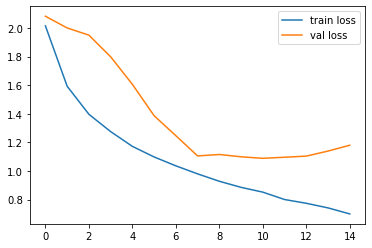

In [ ]:
plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='val loss')
plt.legend();

In [ ]:
test_acc = mlp_score = model.evaluate(X_test, y_test, verbose=0)
print("\n Test_acc =", test_acc[1])


 Test_acc = 0.6129999756813049


С использованием нормализации результат вырос примерно на 5%

In [ ]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

313/313 [==============================] - 18s 15ms/step


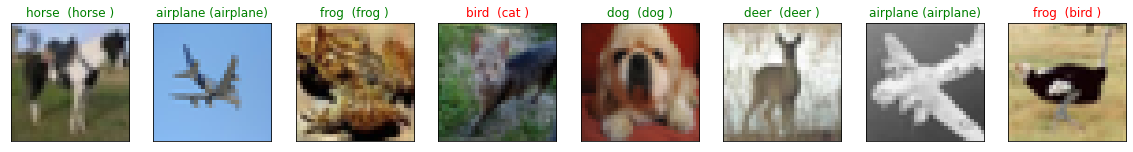

In [ ]:
# Нарисуем результат предсказания. Зеленым цветом название, если верно угадал, красным - неверно. В скобочках правильные ответы

fig = plt.figure(figsize=(20, 10))
indices = np.random.choice(range(len(X_test)), 8)

for i, idx in enumerate(np.random.choice(range(len(X_test)), 8)):
    subplot = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    subplot.imshow(np.squeeze(X_test[idx]))
    pred_idx = np.argmax(y_pred[idx])
    true_idx = y_test[idx]
    subplot.set_title(f'{class_names[pred_idx]} ({class_names[true_idx][0]})',
                 color=("green" if pred_idx == true_idx else "red"))

Для удобства реализуем класс Models, который по сути будет являться списком моделей с двумя методами: add (добавить слой ко всем моделям) и add_create (создать новую модель на основе базовой с дополнительным слоем). Пользоваться им необязательно, но вдруг :)

In [ ]:
from collections import OrderedDict

class Models(OrderedDict):
    def __init__(self, models):
        if not isinstance(models, dict):
            models = OrderedDict({'base_model': models})
        super().__init__(models)

    def add(self, layer):
        for name, model in self.items():
            model.add(layer)

    def add_create(self, name, layer):
        base_model = next(iter(self.items()))[1]
        new_model = keras.models.clone_model(base_model)
        new_model.add(layer)
        self.update({name: new_model})

    def add_update(self, name, layer):
        base_model = self[next(reversed(self))]
        new_model = keras.models.clone_model(base_model)
        new_model.add(layer)
        self.update({name: new_model})

# Example of usage
# models = Models(keras.Sequential())
# models.add(L.InputLayer(input_shape=(32, 32, 3)))
# models.add(L.Convolution2D(filters=10, kernel_size=(3, 3)))
# models.add(L.MaxPooling2D())
# models.add_create('conv_batchnorm', L.BatchNormalization())
# models.add(L.Activation('relu'))
# ...

Прокомментируйте полученные результаты.

**Задание 1.5 (опционально)** Посмотрите на batch_size (параметр model.fit) - при большем батче модель будет быстрее проходить эпохи, но с совсем огромным батчом вам потребуется больше эпох для сходимости (т.к. сеть делает меньше шагов за одну эпоху).
Найдите такое значение, при котором модель быстрее достигает точности 55%. **Hint**: используйте early stopping callback.

In [ ]:
batch_size = 16
mlp_start = time.time()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=3, baseline=0.56) #patience - Number of epochs with no improvement after which training will be stopped

checkpointer = ModelCheckpoint(filepath='MLP.best_weights.hdf5', verbose=1,
                               save_best_only=True)

model = keras.models.Sequential([
    keras.layers.Conv2D(filters=10,
                        kernel_size=(3, 3),
                        padding='same',
                        activation='relu',
                        input_shape=X_train.shape[1:]),
    keras.layers.AveragePooling2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(),
    keras.layers.Flatten(input_shape = X_train.shape[1:]),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(10, activation='softmax')])

model.summary()

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',
                  metrics=['sparse_categorical_accuracy'])

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=15,
          validation_data=(X_val, y_val), callbacks=[callback] + [checkpointer],
          verbose=2, shuffle=True)
print(len(history.history['val_loss']))

mlp_end = time.time()
mlp_took = mlp_end -mlp_start
print("took %s seconds"%(mlp_took))

Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 32, 32, 10)        280       
                                                                 
 average_pooling2d_45 (Avera  (None, 16, 16, 10)       0         
 gePooling2D)                                                    
                                                                 
 batch_normalization_131 (Ba  (None, 16, 16, 10)       40        
 tchNormalization)                                               
                                                                 
 flatten_45 (Flatten)        (None, 2560)              0         
                                                                 
 dense_139 (Dense)           (None, 128)               327808    
                                                                 
 batch_normalization_132 (Ba  (None, 128)            

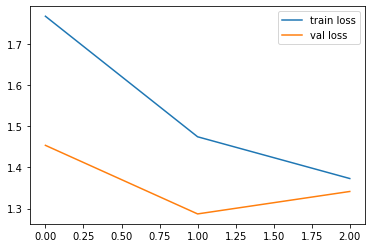

In [ ]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend();

In [ ]:
batch_size = 128
mlp_start = time.time() # for stopwatch

callback = tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=3, baseline=0.56) #patience - Number of epochs with no improvement after which training will be stopped

checkpointer = ModelCheckpoint(filepath='MLP.best_weights.hdf5', verbose=1,
                               save_best_only=True)

model = keras.models.Sequential([
    keras.layers.Conv2D(filters=10,
                        kernel_size=(3, 3),
                        padding='same',
                        activation='relu',
                        input_shape=X_train.shape[1:]),
    keras.layers.AveragePooling2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(),
    keras.layers.Flatten(input_shape = X_train.shape[1:]),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(10, activation='softmax')])

model.summary()
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',
                  metrics=['sparse_categorical_accuracy'])
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=15,
          validation_data=(X_val, y_val), callbacks=[callback] + [checkpointer],
          verbose=2, shuffle=True)
print("number of epochs", len(history.history['val_loss']))

mlp_end = time.time()
mlp_took = mlp_end - mlp_start
print(f"took {mlp_took} seconds")

Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_46 (Conv2D)          (None, 32, 32, 10)        280       
                                                                 
 average_pooling2d_46 (Avera  (None, 16, 16, 10)       0         
 gePooling2D)                                                    
                                                                 
 batch_normalization_134 (Ba  (None, 16, 16, 10)       40        
 tchNormalization)                                               
                                                                 
 flatten_46 (Flatten)        (None, 2560)              0         
                                                                 
 dense_142 (Dense)           (None, 128)               327808    
                                                                 
 batch_normalization_135 (Ba  (None, 128)            

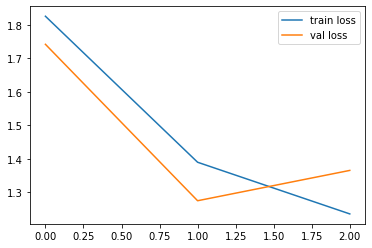

In [ ]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend();

In [ ]:
batch_size = 256
mlp_start = time.time() # for stopwatch

callback = tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=3, baseline=0.56) #patience - Number of epochs with no improvement after which training will be stopped

checkpointer = ModelCheckpoint(filepath='MLP.best_weights.hdf5', verbose=1,
                               save_best_only=True)

model = keras.models.Sequential([
    keras.layers.Conv2D(filters=10,
                        kernel_size=(3, 3),
                        padding='same',
                        activation='relu',
                        input_shape=X_train.shape[1:]),
    keras.layers.AveragePooling2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(),
    keras.layers.Flatten(input_shape = X_train.shape[1:]),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(10, activation='softmax')])

model.summary()
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',
                  metrics=['sparse_categorical_accuracy'])
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=15,
          validation_data=(X_val, y_val), callbacks=[callback] + [checkpointer],
          verbose=2, shuffle=True)
print(len(history.history['val_loss']))

mlp_end = time.time()
mlp_took = mlp_end -mlp_start
print("took %s seconds"%(mlp_took))

Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_47 (Conv2D)          (None, 32, 32, 10)        280       
                                                                 
 average_pooling2d_47 (Avera  (None, 16, 16, 10)       0         
 gePooling2D)                                                    
                                                                 
 batch_normalization_137 (Ba  (None, 16, 16, 10)       40        
 tchNormalization)                                               
                                                                 
 flatten_47 (Flatten)        (None, 2560)              0         
                                                                 
 dense_145 (Dense)           (None, 128)               327808    
                                                                 
 batch_normalization_138 (Ba  (None, 128)            

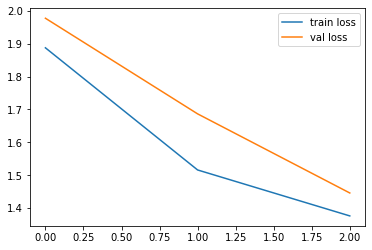

In [ ]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend();

In [ ]:
batch_size = 1028
mlp_start = time.time() # for stopwatch

callback = tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=3, baseline=0.56) #patience - Number of epochs with no improvement after which training will be stopped

checkpointer = ModelCheckpoint(filepath='MLP.best_weights.hdf5', verbose=1,
                               save_best_only=True)

model = keras.models.Sequential([
    keras.layers.Conv2D(filters=10,
                        kernel_size=(3, 3),
                        padding='same',
                        activation='relu',
                        input_shape=X_train.shape[1:]),
    keras.layers.AveragePooling2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(),
    keras.layers.Flatten(input_shape = X_train.shape[1:]),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(10, activation='softmax')])

model.summary()
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',
                  metrics=['sparse_categorical_accuracy'])
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=15,
          validation_data=(X_val, y_val), callbacks=[callback] + [checkpointer],
          verbose=2, shuffle=True)
print(len(history.history['val_loss']))

mlp_end = time.time()
mlp_took = mlp_end -mlp_start
print("took %s seconds"%(mlp_took))


Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 32, 32, 10)        280       
                                                                 
 average_pooling2d_48 (Avera  (None, 16, 16, 10)       0         
 gePooling2D)                                                    
                                                                 
 batch_normalization_140 (Ba  (None, 16, 16, 10)       40        
 tchNormalization)                                               
                                                                 
 flatten_48 (Flatten)        (None, 2560)              0         
                                                                 
 dense_148 (Dense)           (None, 128)               327808    
                                                                 
 batch_normalization_141 (Ba  (None, 128)            

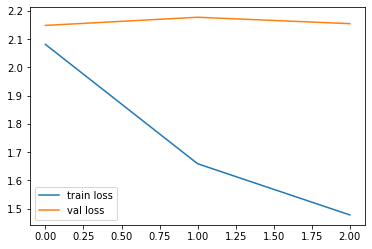

In [ ]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend();

При батчах равных 16, 128, 256, 1028 нужный порог достигался за 3 эпохи. Но чем крупнее батч, тем быстрее проходились эти эпохи.

**Задание 1.6 (опционально)** Попробуйте найти такую комбинацию метода обучения и нормализации, при которой сеть имеет наилучшую кривую обучения. Поясните, что вы понимаете под "наилучшей" кривой обучения.

Наилучшая кривая обучения - кривая ошибок на валидации находится близко к кривой с тренировочных данных, или показывает даже лучшие результаты. При этом желательно по возможности уменьшить затраченное время.

## Свёрточная нейросеть здорового человека

**Задание 1.7 (обязательно попытаться)** Наигравшись выше, обучим большую свёрточную сеть, которая даст на тестовой выборке __accuracy больше 80%__. В этом задании вам потребуется провести эксперименты, сравнив их между собой в конце. Возможно, может быть несколько проще, если писать выводы во время или сразу после каждого эксперимента, после чего сделать общие выводы.

Рекомендуем начать с лучшей модели предыдущего задания и постепенно её улучшать. Вы можете использовать всё, что угодно: любые активации, сколь угодно большие свёрточные слои и глубокие сети. Единственное ограничение: __нельзя использовать предобученные сети и дополнительные данные__.

### Полезные советы
* Для начала, неплохо бы научить что-нибудь побольше, чем 10 фильтров 3x3.
* __Главное правило: одно изменение на эксперимент__. Если у вас есть 2 идеи по улучшению сети, сначала попробуйте их независимо. Может оказаться, что одно из них дало __+10%__ точности а другое __-7%__. А вы так и будете думать, что сделали 2 полезных изменения которые в сумме дают __+3%__. Если какая-то идея не работает — даже если она вам нравится - опишите ее и выкидывайте из дальнейших экспериментов.
* __Be careful or you will dropout__. Дропаут (`L.Dropout`) может позволить вам обучить в несколько раз бОльшую сеть без переобучения, выжав несколько процентов качества. Это круто, но не стоит сразу ставить dropout 50%. Во-первых, слишком сильный дропаут только ухудшит сеть (underfitting). Во-вторых, даже если дропаут улучшает качество, он замедляет обучение. Рекомендуем начинать с небольшого дропаута, быстро провести основные эксперименты, а потом жахнуть в 2 раза больше нейронов и дропаута ~~на ночь~~.
* __Аугментация данных__. Если котика слегка повернуть и подрезать (простите), он всё равно останется котиком. А в керасе есть [удобный класс](https://keras.io/preprocessing/image/), который поставит подрезание котиков на поток. Ещё можно сделать этот трюк в тесте: вертим картинку 10 раз, предсказываем вероятности и усредняем. Только один совет: прежде, чем учить, посмотрите глазами на аугментированные картинки. Если вы сами не можете их различить, то и сеть не сможет.
* __Don't just stack more layers__. Есть более эффективные способы организовать слои, чем простой Sequential. Вот пара идей: [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions](https://arxiv.org/abs/1608.06993). Только не копируйте архитектуру подчистую — вам скорее всего хватит меньшего размера.
* __Долго != плохо__. Более глубокие архитектуры обычно требуют бОльше эпох до сходимости. Это значит, что в первые несколько эпох они могут быть хуже менее глубоких аналогов. Дайте им время, запаситесь чаем и обмажьтесь batch-norm-ом.

#### 1.Добавим еще сверток с постепенным увеличением до 128

In [ ]:
batch_size = 32
steps_per_epoch = int(np.ceil(len(X_train) / batch_size))


mlp_start = time.time() # for stopwatch

checkpointer = ModelCheckpoint(filepath='MLP.best_weights.hdf5', verbose=1,
                               save_best_only=True)

model = keras.models.Sequential([
    keras.layers.Conv2D(filters=32,
                        kernel_size=(3, 3),
                        padding='same',
                        activation='relu',
                        input_shape=X_train.shape[1:]),
    keras.layers.Conv2D(filters=64,
                        kernel_size=(3, 3),
                        padding='same',
                        activation='relu',
                        input_shape=X_train.shape[1:]),
    keras.layers.AveragePooling2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=64,
                        kernel_size=(3, 3),
                        padding='same',
                        activation='relu',
                        input_shape=X_train.shape[1:]),
    keras.layers.Conv2D(filters=128,
                        kernel_size=(3, 3),
                        padding='same',
                        activation='relu',
                        input_shape=X_train.shape[1:]),
    keras.layers.AveragePooling2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(),

    keras.layers.Flatten(input_shape = X_train.shape[1:]),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(10, activation='softmax')])

model.summary()
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',
                  metrics=['sparse_categorical_accuracy'])

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=15,
          validation_data=(X_val, y_val), callbacks=[checkpointer],
          verbose=2, shuffle=True)

print(len(history.history['val_loss']))

mlp_end = time.time()
mlp_took = mlp_end - mlp_start
print("took %s seconds"%(mlp_took))

Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_55 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_56 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 average_pooling2d_52 (Avera  (None, 16, 16, 64)       0         
 gePooling2D)                                                    
                                                                 
 batch_normalization_148 (Ba  (None, 16, 16, 64)       256       
 tchNormalization)                                               
                                                                 
 conv2d_57 (Conv2D)          (None, 16, 16, 64)        36928     
                                                                 
 conv2d_58 (Conv2D)          (None, 16, 16, 128)     

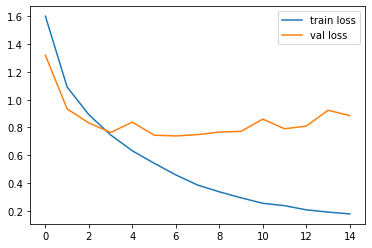

In [ ]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend();

Сильное переобучение. По ходу обучения очень не хватало EarlyStopping, чтобы прервался процесс, если не видно улучшения. Вернем в модель. Можно подумать о повышении dropout, но следующее запустим аугментацию и посмотрим на результаты

#### 2. Аугментация
Аугментация (сдвиг, поворот, изменение цветовой гаммы, увеличение, шумы и др.). Можно посмотреть на ошибки модели и в зависимости категории картинок сделать необходимые действия.

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=20,             #повороты
        width_shift_range=0.2,         #сдвиги
        height_shift_range=0.2,
        shear_range=0.2,               #сдвигающая деформация
        zoom_range=0.2,                #зум
        horizontal_flip=True,          #отображение
        fill_mode='nearest')           #возникшие пустоты из-за смещения картинки, то заполняем по методу nearest

#datagen.fit(X_train)
X_train.shape

(40000, 32, 32, 3)

In [ ]:
dropout = 0.3
batch_size = 32
epochs=15
steps_per_epoch = int(np.ceil(len(X_train) / batch_size))

mlp_start = time.time() # for stopwatch

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3) #patience - Number of epochs with no improvement after which training will be stopped

checkpointer = ModelCheckpoint(filepath='MLP.best_weights.hdf5', verbose=1,
                               save_best_only=True)
#Добавим слои в модель
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=32,
                        kernel_size=(3, 3),
                        padding='same',
                        activation='relu',
                        input_shape=X_train.shape[1:]),
    keras.layers.Conv2D(filters=64,
                        kernel_size=(3, 3),
                        padding='same',
                        activation='relu',
                        input_shape=X_train.shape[1:]),
    keras.layers.AveragePooling2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=64,
                        kernel_size=(3, 3),
                        padding='same',
                        activation='relu',
                        input_shape=X_train.shape[1:]),
    keras.layers.Conv2D(filters=128,
                        kernel_size=(3, 3),
                        padding='same',
                        activation='relu',
                        input_shape=X_train.shape[1:]),
    keras.layers.AveragePooling2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(),

    keras.layers.Flatten(input_shape = X_train.shape[1:]),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(10, activation='softmax')])
model.summary()

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',
                  metrics=['sparse_categorical_accuracy'])

history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),  #добавляем аугментированные изображения через flow
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpointer]+[callback],
                    verbose=2, shuffle=True
                   )

print(len(history.history['val_loss']))

mlp_end = time.time()
mlp_took = mlp_end -mlp_start
print("took %s seconds"%(mlp_took))

Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_63 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_64 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 average_pooling2d_56 (Avera  (None, 16, 16, 64)       0         
 gePooling2D)                                                    
                                                                 
 batch_normalization_156 (Ba  (None, 16, 16, 64)       256       
 tchNormalization)                                               
                                                                 
 conv2d_65 (Conv2D)          (None, 16, 16, 64)        36928     
                                                                 
 conv2d_66 (Conv2D)          (None, 16, 16, 128)     

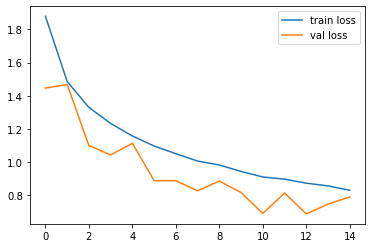

In [ ]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend();

Cходимость в процессе обучения оказалась медленнее, обучаться модели на всяких разных "кривых" картинках стало труднее, но если увелить еще количество эпох результат будет лучше, потому что найдутся закономерности и для кривых картинок, тогда лучше смогут определить потом на неподготовленных данных закономерности. Очень радует, что на тестовых данных результат лучше.

3. Пробуем другие модели с обходными путями. В частности Resnet

In [ ]:
mlp_start = time.time() # for stopwatch
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3) #patience - Number of epochs with no improvement after which training will be stopped
checkpointer = ModelCheckpoint(filepath='MLP.best_weights.hdf5', verbose=1,
                               save_best_only=True)
dropout = 0.3
batch_size = 32
epochs=15
steps_per_epoch = int(np.ceil(len(X_train) / batch_size))

inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu")(inputs)
x = layers.Conv2D(64, 3, activation="relu")(x)
block_1_output = layers.MaxPooling2D(3)(x)

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_1_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_2_output = layers.add([x, block_1_output])

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_2_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_3_output = layers.add([x, block_2_output])

x = layers.Conv2D(64, 3, activation="relu")(block_3_output)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation='softmax')(x)


model = keras.Model(inputs, outputs, name="toy_resnet")
model.summary()


model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size), steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpointer]+[callback],
                    verbose=2, shuffle=True
                   )
print(len(history.history['val_loss']))

mlp_end = time.time()
mlp_took = mlp_end -mlp_start
print("took %s seconds"%(mlp_took))


Model: "toy_resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_123 (Conv2D)            (None, 30, 30, 32)   896         ['input_4[0][0]']                
                                                                                                  
 conv2d_124 (Conv2D)            (None, 28, 28, 64)   18496       ['conv2d_123[0][0]']             
                                                                                                  
 max_pooling2d_8 (MaxPooling2D)  (None, 9, 9, 64)    0           ['conv2d_124[0][0]']             
                                                                                         

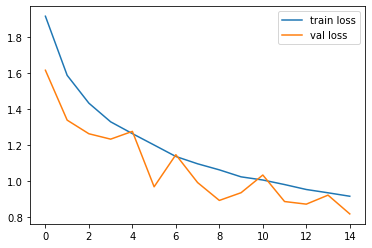

In [ ]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend();

Посмотрим на визуализацию

In [ ]:
evaluation = model.evaluate(X_test, y_test)
print(f'Test Accuracy : {evaluation[1] * 100:.2f}%')

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred)


313/313 [==============================] - 29s 86ms/step - loss: 0.8349 - sparse_categorical_accuracy: 0.7233
Test Accuracy : 72.33%
313/313 [==============================] - 29s 85ms/step


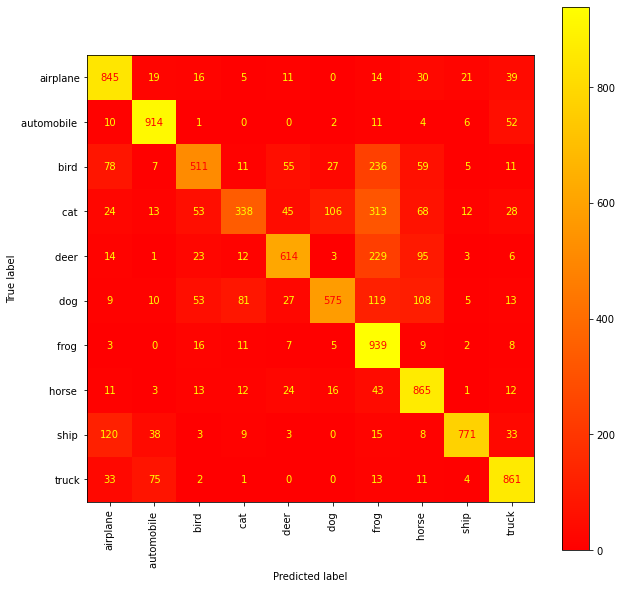

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)


fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax,cmap='autumn')

plt.show()

Модели понравились лягушки, всех захотела туда записать. Не понравились кошки, решила превратить их в ляшушек.

In [ ]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

313/313 [==============================] - 28s 83ms/step


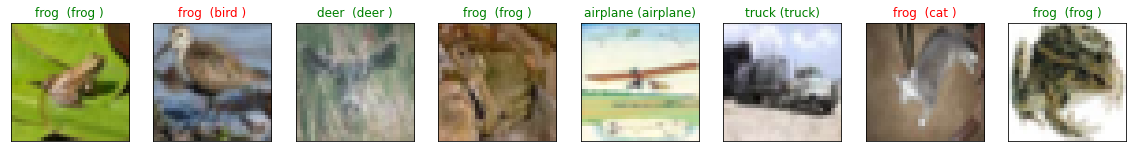

In [ ]:

# Нарисуем результат предсказания. Зеленым цветом название, если верно угадал, красным - неверно. В скобочках правильные ответы

fig = plt.figure(figsize=(20, 10))
indices = np.random.choice(range(len(X_test)), 8)

for i, idx in enumerate(np.random.choice(range(len(X_test)), 8)):
    subplot = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    subplot.imshow(np.squeeze(X_test[idx]))
    pred_idx = np.argmax(y_pred[idx])
    true_idx = y_test[idx]
    subplot.set_title(f'{class_names[pred_idx]} ({class_names[true_idx][0]})',
                 color=("green" if pred_idx == true_idx else "red"))

In [ ]:
keras.utils.plot_model(model, "mini_resnet.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


А теперь, опишите свои <s>ощущения</s> результаты от проведенных экспериментов.

Удалось нащупать самостоятельно, без подглядывания в готовые решения нужное направление. Если добавить эпох, то можно будет получить цифры за 80%. Подглядев сейчас в готовые решения, можно посмотреть интересные варианты там с разным количеством сверток, строением модели. Очень интересна для меня оказалась аугментация данных. Единственное, что пробовала запустить ее не к дата сету, а добавить Image augmentation layers (https://keras.io/guides/preprocessing_layers/), но что-то делала не так и результаты очень плохие. Ошибки по типу таких выдавал: WARNING:tensorflow:Using a while_loop for converting Bitcast cause there is no registered converter for this op. Даунгрейд библиотеки к 2.8.3 не дал результата. Если поделитесь мудростью, буду рада!